In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots
import time

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

In [2]:
np.random.seed(0)

from merfish_datasets import merfish_datasets
directories = merfish_datasets
print(merfish_datasets)

{'P14NRa_ant': 'merfish_06142023/ant/region0', 'P28NRa_ant': 'merfish_06142023/ant/region1', 'P14NRa_pos': 'merfish_06142023/pos/region0', 'P28NRa_pos': 'merfish_06142023/pos/region1', 'P21NRa_ant': 'merfish_20231114/region0', 'P21DRa_ant': 'merfish_20231114/region2', 'P28DRa_ant': 'merfish_20231114/region1', 'P21NRa_pos': 'merfish_20231120/region0', 'P21DRa_pos': 'merfish_20231120/region1', 'P28DRa_pos': 'merfish_20231120/region2', 'P14NRb_ant': 'merfish_202404051211/region_0', 'P28NRb_ant': 'merfish_202404051211/region_1', 'P14NRb_pos': 'merfish_202404051214/region_0', 'P28NRb_pos': 'merfish_202404051214/region_1', 'P21NRb_ant': 'merfish_202404091526/region_2', 'P21DRb_ant': 'merfish_202404091526/region_1', 'P28DRb_ant': 'merfish_202404091526/region_0', 'P21NRb_pos': 'merfish_202404091601/region_0', 'P21DRb_pos': 'merfish_202404091601/region_2', 'P28DRb_pos': 'merfish_202404091601/region_1', 'P14NR_ant': 'merfish_06142023/ant/region0', 'P28NR_ant': 'merfish_06142023/ant/region1', 'P1

In [3]:
name = 'P28NRa_pos'
dirc = directories[name]

full_dirc = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/{dirc}/'
f1   = full_dirc + 'detected_transcripts.csv'
fout = full_dirc + 'detected_transcripts_v1l23_241010.csv'

f_main_l0 = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_l0_hemibrain_240723.h5ad'
f_main_l2 = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_l2_v1_240723.h5ad'

In [4]:
adata_l0 = ad.read(f_main_l0, backed='r')
adata_l2 = ad.read(f_main_l2, backed='r')
adata_l0, adata_l2

(AnnData object with n_obs × n_vars = 118468 × 500 backed at '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28NRa_pos_l0_hemibrain_240723.h5ad'
     obs: 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DAPI_raw', 'DAPI_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y', 'blended_domains', 'x2', 'y2', 'depth', 'width'
     uns: 'leiden', 'neighbors', 'ref_line', 'rotation', 'xy'
     obsm: 'X_pca', 'X_xy', 'blanks'
     layers: 'jnorm', 'norm'
     obsp: 'connectivities', 'distances', 'xy_connectivities', 'xy_distances',
 AnnData object with n_obs × n_vars = 9816 × 500 backed at '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28NRa_pos_l2_v1_240723.h5ad'
     obs: 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_rat

In [5]:
bound_l, bound_r = adata_l2.uns['v1_window']
bound_d = 400

cond = np.all([
    adata_l2.obs['width'] > bound_l, 
    adata_l2.obs['width'] < bound_r, 
    adata_l2.obs['depth'] < bound_d, 
], axis=0)
adatasub = adata_l2[cond]

rotation_angle = adata_l2.uns['rotation']
ref_line = np.array(adata_l2.uns['ref_line'])

# get FOVs
fovs = np.unique(adatasub.obs['fov'])
fovs.shape, fovs

((32,),
 array([2155, 2156, 2158, 2159, 2160, 2202, 2203, 2204, 2205, 2206, 2207,
        2208, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2296, 2297, 2298,
        2299, 2300, 2301, 2302, 2303, 2340, 2341, 2342, 2343, 2344]))

# get transcripts in V1 L2/3

In [6]:
# go over all tranascripts - select only those that are within these FOVs
chunks = pd.read_csv(f1, chunksize=1000000)
dfsubs = []

ti = time.time()
for i, chunk in enumerate(chunks):
    print(i, time.time()-ti)
    dfsub = chunk[chunk['fov'].isin(fovs)]
    if len(dfsub) > 0:
        print(len(dfsub))
        dfsubs.append(dfsub)

0 0.7923753261566162
1 1.4755322933197021
2 2.141171455383301
3 2.7972705364227295
4 3.4313011169433594
5 4.076771974563599
6 4.711731195449829
7 5.336335897445679
8 5.967113971710205
9 6.615061044692993
10 7.237733602523804
11 7.872718811035156
12 8.507813215255737
13 9.139692544937134
14 9.788958549499512
15 10.412566661834717
16 11.02940034866333
17 11.674752950668335
18 12.29099440574646
19 12.91474723815918
20 13.53612494468689
21 14.1566321849823
22 14.792245388031006
23 15.436853170394897
24 16.04652738571167
25 16.67463731765747
26 17.285707235336304
27 17.94176983833313
28 18.5920352935791
29 19.217841863632202
30 19.837552785873413
31 20.45919895172119
32 21.090578079223633
33 21.73225712776184
34 22.362659215927124
35 22.98638153076172
36 23.616816997528076
37 24.246615648269653
38 24.892427682876587
39 25.517918348312378
40 26.143635511398315
41 26.768208265304565
42 27.420884609222412
43 28.05672025680542
44 28.713542938232422
45 29.341670751571655
46 29.963654279708862
47

In [7]:
df_v1l23 = pd.concat(dfsubs)
df_v1l23

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id
77467837,18,0,864.09937,7355.5910,0.0,734.4202,194.90173,2155,Cdh4,ENSMUST00000000314,-1
77467838,26,0,929.32420,7361.7090,0.0,1338.3541,251.54848,2155,Cdh4,ENSMUST00000000314,-1
77467839,31,0,950.52520,7367.0760,0.0,1534.6597,301.24652,2155,Cdh4,ENSMUST00000000314,2596588902763100019
77467840,41,0,950.61080,7371.1533,0.0,1535.4518,339.00000,2155,Cdh4,ENSMUST00000000314,-1
77467841,56,0,979.42970,7380.3096,0.0,1802.2937,423.77660,2155,Cdh4,ENSMUST00000000314,-1
...,...,...,...,...,...,...,...,...,...,...,...
95231859,125,453,1360.67640,9288.3330,6.0,1686.6150,1175.78190,2344,Apoe,ENSMUST00000174064,-1
95231860,22,458,1329.72190,9250.4240,6.0,1400.0000,824.76794,2344,Pou3f2,ENSMUST00000178174,-1
95231861,6,464,1290.99910,9178.8640,6.0,1041.4554,162.18051,2344,Unc13c,ENSMUST00000184666,-1
95231862,74,492,1370.56910,9234.1130,6.0,1778.2141,673.74994,2344,Sox10,ENSMUST00000230532,2596588903494100030


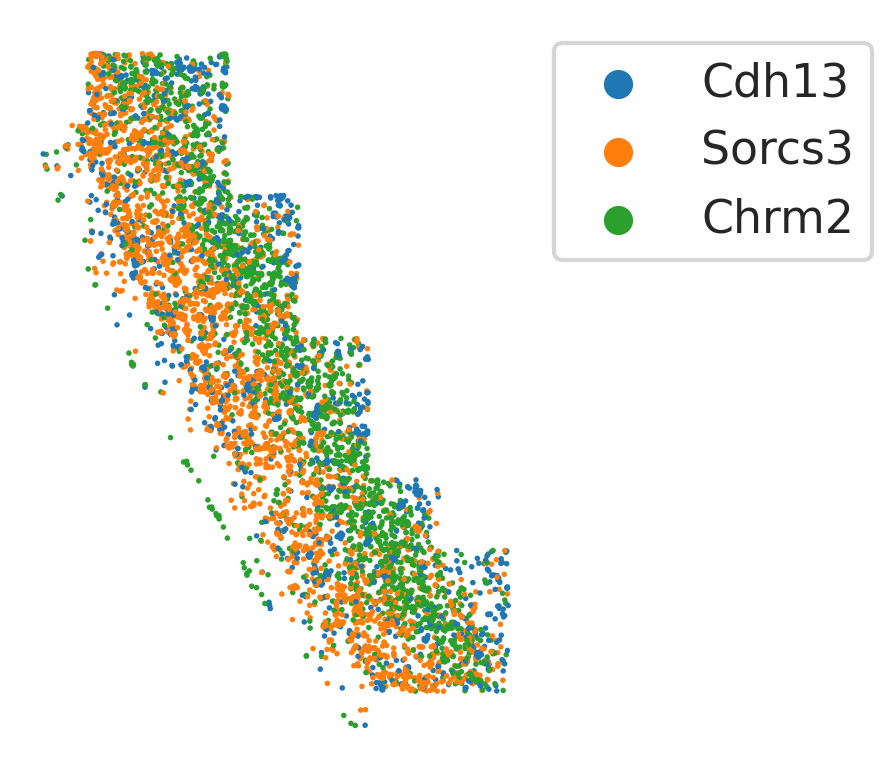

In [8]:
# check results
query_genes = ['Cdh13', 'Sorcs3', 'Chrm2']

abc = df_v1l23[df_v1l23['gene'].isin(query_genes)]  
fig, ax = plt.subplots()
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='global_x', y='global_y', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()

# rotate, calc depth and width, and viz

In [9]:
from merfish_datasets import merfish_datasets_params

# (center_x, center_y) raw 
# (x,y) rotation1 
# (x2,y2) rotation2, subtract mean

# get the original operations

# (rotation 1 + rotation 2) -> -(xshift, yshift)

rotations = merfish_datasets_params[name]
alpha1, alpha2 = rotations['rotation'], rotations['rotation2']

xr2, yr2 = utils_merfish.rot2d(adata_l0.obs['x'].values, 
                               adata_l0.obs['y'].values,
                               alpha2) #adata_l0.obs['x']
## check
# plt.scatter(xr2-xshift, adata_l0.obs['x2'])
xshift = np.mean(xr2)
yshift = np.mean(yr2)

In [10]:
# reference line
ref_line_obj = utils_merfish.RefLineSegs(ref_line)

In [11]:
%%time
x = df_v1l23['global_x'].values
y = df_v1l23['global_y'].values

xr, yr = utils_merfish.rot2d(x, y, alpha1+alpha2)
xr = xr - xshift 
yr = yr - yshift 
XY = np.vstack([xr, yr]).T 

df_v1l23['x'] = xr
df_v1l23['y'] = yr
df_v1l23['depth'] = ref_line_obj.ndist_to_qps(XY)
df_v1l23['width'] = ref_line_obj.tdist_to_qps(XY)

cond_spots = np.all([
    df_v1l23['width'] > bound_l, 
    df_v1l23['width'] < bound_r, 
    df_v1l23['depth'] < bound_d, 
], axis=0)

df_v1l23_new = df_v1l23[cond_spots]

CPU times: user 7.94 s, sys: 7.18 s, total: 15.1 s
Wall time: 15.1 s


In [13]:
abc = df_v1l23_new[df_v1l23_new['gene'].isin(query_genes)]  

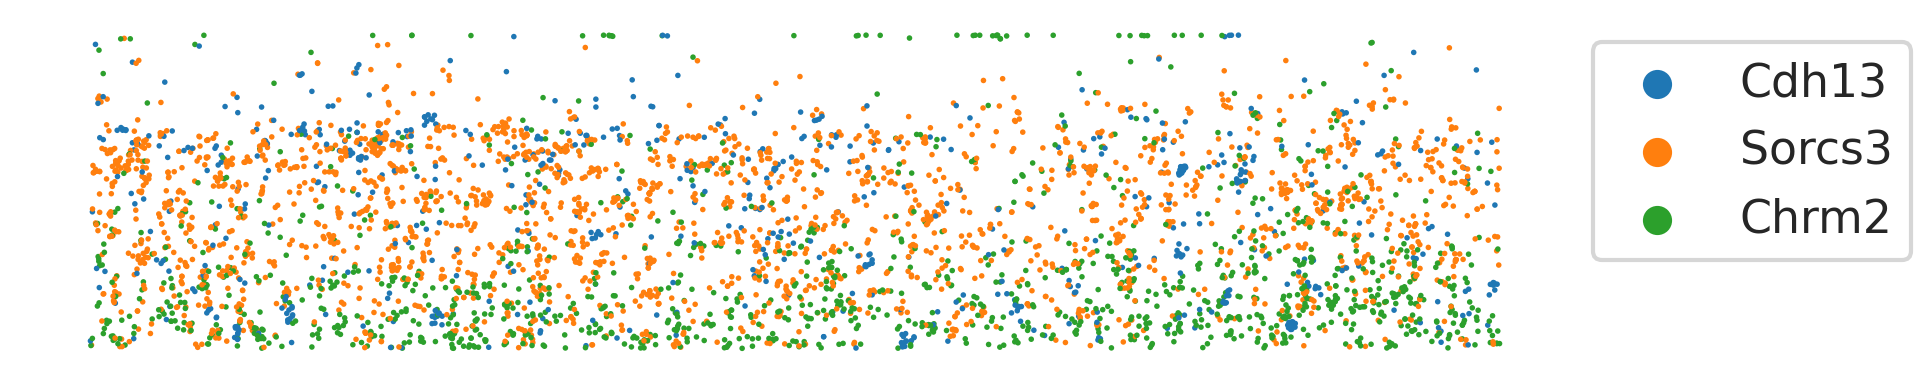

In [14]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='width', y='depth', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()

# Save results

In [15]:
df_v1l23

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
77467837,18,0,864.09937,7355.5910,0.0,-1825.207555,1254.118113,2155,Cdh4,ENSMUST00000000314,-1,487.034229,1404.630212
77467838,26,0,929.32420,7361.7090,0.0,-1774.760556,1212.323273,2155,Cdh4,ENSMUST00000000314,-1,545.055648,1435.047695
77467839,31,0,950.52520,7367.0760,0.0,-1755.974143,1201.126944,2155,Cdh4,ENSMUST00000000314,2596588902763100019,562.560492,1452.161312
77467840,41,0,950.61080,7371.1533,0.0,-1753.030528,1203.949502,2155,Cdh4,ENSMUST00000000314,-1,561.064374,1455.955166
77467841,56,0,979.42970,7380.3096,0.0,-1726.178007,1190.045944,2155,Cdh4,ENSMUST00000000314,-1,584.109014,1475.533506
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95231859,125,453,1360.67640,9288.3330,6.0,-107.419595,2269.640102,2344,Apoe,ENSMUST00000174064,-1,4.427451,3397.304354
95231860,22,458,1329.72190,9250.4240,6.0,-156.113443,2264.722528,2344,Pou3f2,ENSMUST00000178174,-1,1.020377,3348.481560
95231861,6,464,1290.99910,9178.8640,6.0,-234.095158,2241.503121,2344,Unc13c,ENSMUST00000184666,-1,9.717289,3267.485648
95231862,74,492,1370.56910,9234.1130,6.0,-138.763729,2224.305577,2344,Sox10,ENSMUST00000230532,2596588903494100030,43.793254,3358.729654


In [16]:
df_v1l23.to_csv(fout, header=True, index=False)
!head $fout

Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
18,0,864.09937,7355.591,0.0,-1825.2075546897922,1254.118113064334,2155,Cdh4,ENSMUST00000000314,-1,487.03422923638493,1404.6302117757364
26,0,929.3242,7361.709,0.0,-1774.760555807754,1212.3232727568934,2155,Cdh4,ENSMUST00000000314,-1,545.0556482302459,1435.0476954071557
31,0,950.5252,7367.076,0.0,-1755.974142845189,1201.1269439835855,2155,Cdh4,ENSMUST00000000314,2596588902763100019,562.5604915465906,1452.1613117053903
41,0,950.6108,7371.1533,0.0,-1753.030528025788,1203.9495021220478,2155,Cdh4,ENSMUST00000000314,-1,561.0643736958983,1455.955166476838
56,0,979.4297,7380.3096,0.0,-1726.1780065888724,1190.0459443262894,2155,Cdh4,ENSMUST00000000314,-1,584.1090139038986,1475.5335061557746
58,0,865.7034,7381.6177,0.0,-1805.6696781376577,1271.3875486360153,2155,Cdh4,ENSMUST00000000314,2596588902762100042,478.6392862761717,1429.3180014262025
60,0,882.41003,7383.32,0.0,-1792.6525989002694,1260.77788514